# Flow Dashboard

Display visualizations from Github data.


## Setup

In [137]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from functools import reduce

# Date tools
from datetime import date
from dateutil.relativedelta import relativedelta, SU
from matplotlib.dates import DateFormatter

# Prep Plots

# Bigger text
plt.rc('font', size=12)


def plotPie(df, title, xLabel):
    def label_point(pct, allvals):
        absolute = int(np.round(pct/100.*np.sum(allvals)))
        return "{:.1f}%\n({:d})".format(pct, absolute)

    print()
    plt.figure(figsize=(10, 5))
    plt.title(title, fontsize=20)
    df.sum().plot(kind='pie', legend=False,
                  autopct=lambda pct: label_point(pct, df.sum()),
                  pctdistance=1.16, labeldistance=.4)
    plt.ylabel(None)  # Clear yLabel
    plt.xlabel(xLabel, fontsize=16)
    plt.show()

# Date utils


def get_previous_sunday(working_date=date.today()):
    last_sunday = working_date + relativedelta(weekday=SU(-1))
    return last_sunday.strftime("%Y-%m-%d")

# Plot utils


def plot_line(df, title, xlabel, ylabel, lines):
    plt.figure(figsize=(20, 10), facecolor='white')
    plt.title(title, fontsize=20)
    for l in lines:
        df[l['col']].plot(color=l['color'], label=l['label'],
                          legend=True).set_ybound(0)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()


def plot_bar(df, title, xlabel, ylabel, lines):
    plt.figure(figsize=(20, 10), facecolor='white')
    plt.title(title, fontsize=20)
    for l in lines:
        df[l['col']].plot(kind='bar', color=l['color'], legend=True) \
            .xaxis.set_major_formatter(DateFormatter("%Y-%m-%d"))

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()


# DF utils

def pivot_with_zeros(df, index, columns, values):
    df = df.pivot(index, columns, values)

    # Replace NaN
    df = df.fillna(0)

    return df


In [138]:
# Read PRs
prs = pd.read_csv('prs_data.csv', parse_dates=[
                  'closedAt', 'createdAt', 'updatedAt']).set_index('number')

prs


,title,author,assignees,url,state,closedAt,createdAt,updatedAt,labels,issues
number,,,,,,,,,,
1743,added baseprice and added check for blocknumber,NirajBhattarai,{'NirajBhattarai'},https://github.com/weiks/esports-backend/pull/...,OPEN,NaT,2022-07-05 08:48:34+00:00,2022-07-05 19:47:13+00:00,set(),[]
1738,definition added for vesting,NirajBhattarai,{'NirajBhattarai'},https://github.com/weiks/esports-backend/pull/...,OPEN,NaT,2022-07-04 11:36:57+00:00,2022-07-05 19:45:47+00:00,{'enhancement'},"[{'assignees': {'NirajBhattarai', 'bmcilw1'}, ..."
1742,1739 yunite invite link,gonzalovelasco,{'gonzalovelasco'},https://github.com/weiks/esports-backend/pull/...,MERGED,2022-07-05 19:44:50+00:00,2022-07-04 20:54:27+00:00,2022-07-05 19:44:50+00:00,{'enhancement'},"[{'assignees': {'gonzalovelasco', 'brianmazzoc..."
1746,state should be immutable :))),CarlosViller,{'CarlosViller'},https://github.com/weiks/esports-backend/pull/...,OPEN,NaT,2022-07-05 19:37:50+00:00,2022-07-05 19:41:04+00:00,set(),[]
1745,Gracefully shutdown HTTP server,Mathspy,{'Mathspy'},https://github.com/weiks/esports-backend/pull/...,MERGED,2022-07-05 17:14:28+00:00,2022-07-05 15:24:10+00:00,2022-07-05 17:14:29+00:00,set(),[]
...,...,...,...,...,...,...,...,...,...,...
6,Add auth middleware to discord/token endpoint,Mathspy,{'Mathspy'},https://github.com/weiks/esports-backend/pull/6,MERGED,2020-03-18 01:17:28+00:00,2020-03-18 01:16:02+00:00,2020-03-18 01:17:34+00:00,set(),[]
5,Add users to db on successful OAuth,Mathspy,{'Mathspy'},https://github.com/weiks/esports-backend/pull/5,MERGED,2020-03-17 22:39:52+00:00,2020-03-17 22:33:44+00:00,2020-03-17 22:39:55+00:00,set(),[]
4,Swapped REDIRECT_URI to be env var based,Mathspy,{'Mathspy'},https://github.com/weiks/esports-backend/pull/4,MERGED,2020-03-14 21:08:57+00:00,2020-03-14 21:00:49+00:00,2020-03-14 21:09:00+00:00,set(),[]


In [139]:
# Read Issues
issues = pd.read_csv('issues_data.csv', parse_dates=[
    'closedAt', 'createdAt', 'updatedAt']).set_index('number')


issues


,title,author,assignees,url,state,closedAt,createdAt,updatedAt,labels
number,,,,,,,,,
1739,Add a field for host to post invite link to se...,SinshiSmith,"{'gonzalovelasco', 'brianmazzocchi'}",https://github.com/weiks/esports-backend/issue...,CLOSED,2022-07-05 19:46:03+00:00,2022-07-04 14:29:30+00:00,2022-07-05 19:46:03+00:00,{'enhancement'}
1463,[Bug] 'Edit event' button not enabled for CREA...,P3NGUIN1,{'mikiasyonas'},https://github.com/weiks/esports-backend/issue...,OPEN,NaT,2022-05-16 20:17:49+00:00,2022-07-05 18:56:39+00:00,"{'good for newcomers', 'bug', 'critical'}"
1148,[Milestone] Intergate Challonge as a replaceme...,bmcilw1,set(),https://github.com/weiks/esports-backend/issue...,OPEN,NaT,2022-04-07 22:08:53+00:00,2022-07-05 17:42:38+00:00,{'enhancement'}
1061,[Milestone] Swap War Legends (WLS) to Yunite f...,bmcilw1,"{'Mathspy', 'alexangc'}",https://github.com/weiks/esports-backend/issue...,OPEN,NaT,2022-03-22 18:04:30+00:00,2022-07-05 16:58:09+00:00,{'enhancement'}
1508,[Frontend] Add drop-down to select the Yunite ...,Mathspy,{'CarlosViller'},https://github.com/weiks/esports-backend/issue...,CLOSED,2022-07-05 16:57:22+00:00,2022-05-24 18:53:39+00:00,2022-07-05 16:57:22+00:00,set()
...,...,...,...,...,...,...,...,...,...
527,[Airbrake] [Production] 10 ABORTED: The refere...,weiks,{'Mathspy'},https://github.com/weiks/esports-backend/issue...,CLOSED,2021-03-31 14:43:40+00:00,2021-03-11 08:16:28+00:00,2021-03-31 14:43:40+00:00,set()
392,[Airbrake] [Production] Cannot read property '...,weiks,set(),https://github.com/weiks/esports-backend/issue...,CLOSED,2021-01-23 20:47:12+00:00,2021-01-23 17:12:17+00:00,2021-01-23 20:47:12+00:00,set()
391,"[Airbrake] [Production] Value for argument ""do...",weiks,set(),https://github.com/weiks/esports-backend/issue...,CLOSED,2021-01-23 20:38:37+00:00,2021-01-23 16:48:08+00:00,2021-01-23 20:38:37+00:00,set()


## PRs Over Time

### Total PRs Over Time

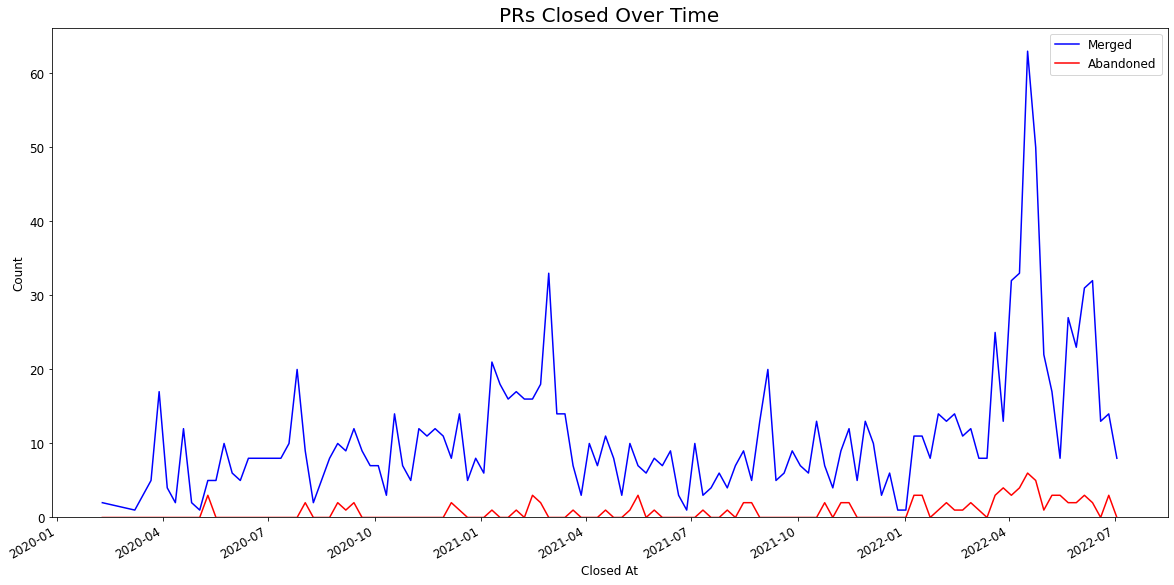

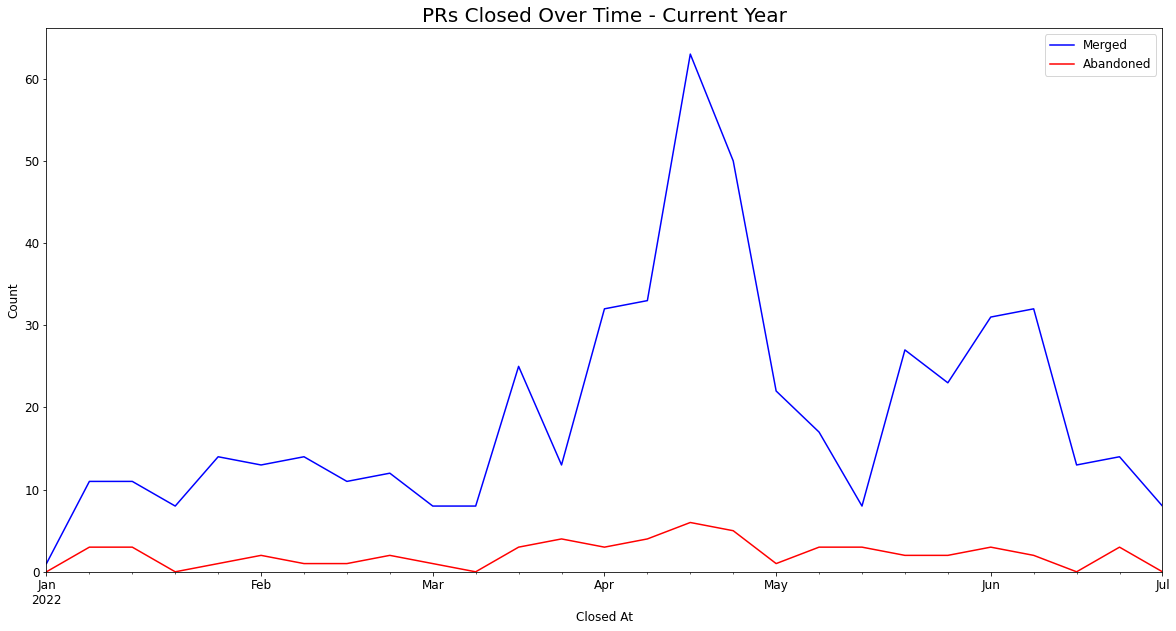

In [140]:
# Count CLOSED/MERGED items per week
weekly_prs = prs.set_index('closedAt').groupby(
    [pd.Grouper(freq='W', label='left'), pd.Grouper('state')])['state'].count().reset_index(name='count')

weekly_prs_pivot = pivot_with_zeros(weekly_prs, 'closedAt', 'state', 'count')

plot_line(weekly_prs_pivot, 'PRs Closed Over Time', 'Closed At', 'Count', [
          {'col': 'MERGED', 'color': 'blue', 'label': 'Merged'}, {'col': 'CLOSED', 'color': 'red', 'label': 'Abandoned'}])

# Filter to current year
weekly_prs_year = weekly_prs[weekly_prs['closedAt'].dt.year == date.today(
).year]

weekly_prs_pivot_year = pivot_with_zeros(
    weekly_prs_year, 'closedAt', 'state', 'count')

plot_line(weekly_prs_pivot_year, 'PRs Closed Over Time - Current Year', 'Closed At', 'Count', [
          {'col': 'MERGED', 'color': 'blue', 'label': 'Merged'}, {'col': 'CLOSED', 'color': 'red', 'label': 'Abandoned'}])


## Issues Over Time

### Total Issues Over Time

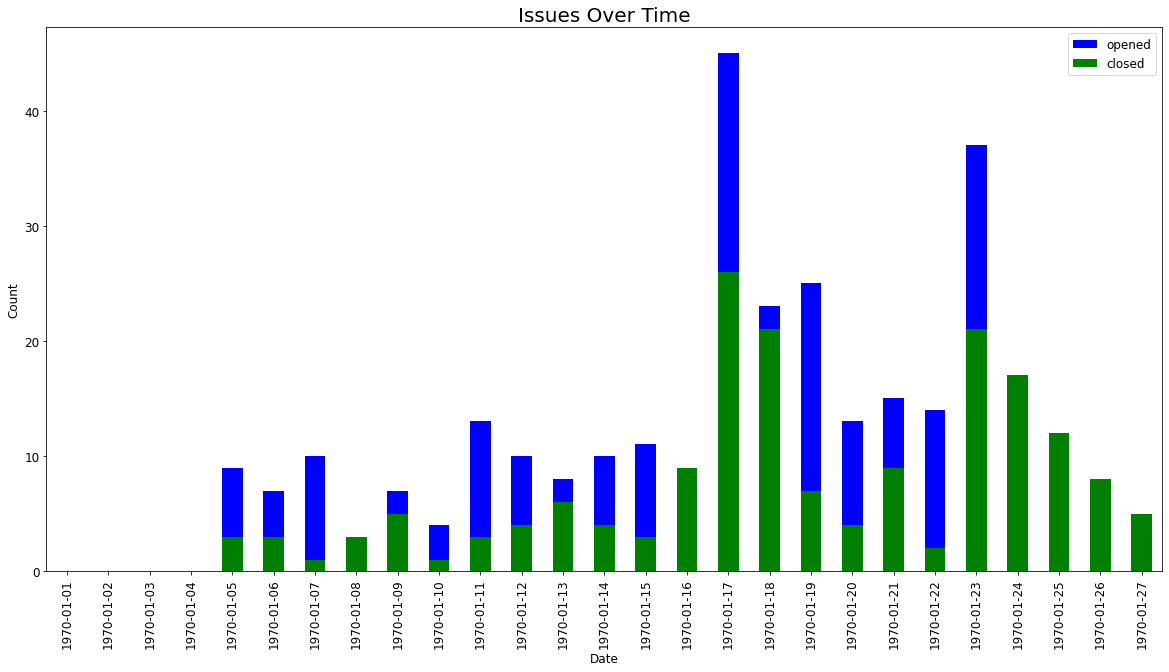

In [141]:
weekly_closed_issues = issues.set_index('closedAt').groupby(
    pd.Grouper(freq='W', label='left'))['state'].count().reset_index(name='closed')

weekly_closed_issues.rename(columns={'closedAt': 'date'}, inplace=True)

weekly_created_issues = issues.set_index('createdAt').groupby(
    pd.Grouper(freq='W', label='left'))['state'].count().reset_index(name='opened')

weekly_created_issues.rename(columns={'createdAt': 'date'}, inplace=True)

weekly_issues = weekly_closed_issues.merge(
    weekly_created_issues, how='outer', on='date').set_index('date').sort_index()

# Replace NaN
weekly_issues = weekly_issues.fillna(0)

# Filter to current year
weekly_issues = weekly_issues[weekly_issues.index.year == date.today().year]

plot_bar(weekly_issues, 'Issues Over Time', 'Date', 'Count', [
         {'col': 'opened', 'color': 'blue'}, {'col': 'closed', 'color': 'green'}])


### Bugs Opened & Closed Over Time

In [142]:
issues

,title,author,assignees,url,state,closedAt,createdAt,updatedAt,labels
number,,,,,,,,,
1739,Add a field for host to post invite link to se...,SinshiSmith,"{'gonzalovelasco', 'brianmazzocchi'}",https://github.com/weiks/esports-backend/issue...,CLOSED,2022-07-05 19:46:03+00:00,2022-07-04 14:29:30+00:00,2022-07-05 19:46:03+00:00,{'enhancement'}
1463,[Bug] 'Edit event' button not enabled for CREA...,P3NGUIN1,{'mikiasyonas'},https://github.com/weiks/esports-backend/issue...,OPEN,NaT,2022-05-16 20:17:49+00:00,2022-07-05 18:56:39+00:00,"{'good for newcomers', 'bug', 'critical'}"
1148,[Milestone] Intergate Challonge as a replaceme...,bmcilw1,set(),https://github.com/weiks/esports-backend/issue...,OPEN,NaT,2022-04-07 22:08:53+00:00,2022-07-05 17:42:38+00:00,{'enhancement'}
1061,[Milestone] Swap War Legends (WLS) to Yunite f...,bmcilw1,"{'Mathspy', 'alexangc'}",https://github.com/weiks/esports-backend/issue...,OPEN,NaT,2022-03-22 18:04:30+00:00,2022-07-05 16:58:09+00:00,{'enhancement'}
1508,[Frontend] Add drop-down to select the Yunite ...,Mathspy,{'CarlosViller'},https://github.com/weiks/esports-backend/issue...,CLOSED,2022-07-05 16:57:22+00:00,2022-05-24 18:53:39+00:00,2022-07-05 16:57:22+00:00,set()
...,...,...,...,...,...,...,...,...,...
527,[Airbrake] [Production] 10 ABORTED: The refere...,weiks,{'Mathspy'},https://github.com/weiks/esports-backend/issue...,CLOSED,2021-03-31 14:43:40+00:00,2021-03-11 08:16:28+00:00,2021-03-31 14:43:40+00:00,set()
392,[Airbrake] [Production] Cannot read property '...,weiks,set(),https://github.com/weiks/esports-backend/issue...,CLOSED,2021-01-23 20:47:12+00:00,2021-01-23 17:12:17+00:00,2021-01-23 20:47:12+00:00,set()
391,"[Airbrake] [Production] Value for argument ""do...",weiks,set(),https://github.com/weiks/esports-backend/issue...,CLOSED,2021-01-23 20:38:37+00:00,2021-01-23 16:48:08+00:00,2021-01-23 20:38:37+00:00,set()


In [143]:
bugs = issues['bug' in issues['labels']]

bugs


KeyError: False

### Enhancements Closed Over Time